<a href="https://colab.research.google.com/github/apester/PINN/blob/main/diffphys-code-burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Burgers Optimization with a Differentiable Physics Gradient

To illustrate the process of computing gradients in a _differentiable physics_ (DP) setting, we target the same inverse problem (the reconstruction task) used for the PINN example  in {doc}`physicalloss-code`. The choice of DP as a method has some immediate implications: we start with a discretized PDE, and the evolution of the  system is now fully determined by the resulting numerical solver. Hence, the only real unknown is the initial state. We will still need to re-compute all the states between the initial and target state many times, just now we won't need an NN for this step. Instead, we rely on the discretization of the model equations.

Also, as we choose an initial discretization for the DP approach, the unknown initial state consists of the sampling points of the involved physical fields, and we can simply represent these unknowns as floating point variables. Hence, even for the initial state we do not need to set up an NN. Thus, our Burgers reconstruction problem reduces to a gradient-based optimization without any NN when solving it with DP. Nonetheless, it's a very good starting point to illustrate the process.

First, we'll set up our discretized simulation. Here we employ phiflow, as shown in the overview section on _Burgers forward simulations_.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/diffphys-code-burgers.ipynb)


## Initialization

phiflow directly gives us a sequence of differentiable operations, provided that we don't use the _numpy_ backend.
The important step here is to include `phi.tf.flow` instad of `phi.flow` (for _pytorch_ you could use `phi.torch.flow`).

So, as a first step, let's set up some constants, and initialize a `velocity` field with zeros, and our constraint at $t=0.5$ (step 16), now as a `CenteredGrid` in phiflow. Both are using periodic boundary conditions (via `extrapolation.PERIODIC`) and a spatial discretization of $\Delta x = 1/128$.


In [1]:
!pip install --upgrade --quiet phiflow==3.4
from phi.tf.flow import *

N = 128
DX = 2/N
STEPS = 32
DT = 1/STEPS
NU = 0.01/(N*np.pi)

# allocate velocity grid
velocity = CenteredGrid(0, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))

# and a grid with the reference solution
REFERENCE_DATA = math.tensor([0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] , math.spatial('x'))
SOLUTION_T16 = CenteredGrid( REFERENCE_DATA, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.7/356.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Below we verify that the fields of our simulation are now backed by TensorFlow.

In [2]:
type(velocity.values.native())

tensorflow.python.framework.ops.EagerTensor

## Gradients

The `math.gradient` operation of phiflow generates a gradient function for a scalar loss, and we use it below to compute gradients of a whole simulation with the chosen number of 32 time steps.

To use it for the Burgers case we need to compute an appropriate loss: we want the solution at $t=0.5$ to match the reference data. Thus we simply compute an $L^2$ difference between step number 16 and our constraint array as `loss`. Afterwards, we evaluate the gradient function of the initial velocity state `velocity` with respect to this loss. Phiflow's `math.gradient` generates a function that returns a gradient for each parameter, and as we only have a single one in form of the velocity here, `grad[0]` represents the gradient for the initial velocity.

In [3]:
def loss_function(velocity):
    velocities = [velocity]
    for time_step in range(STEPS):
        v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, substeps=1)
        v2 = advect.semi_lagrangian(v1, v1, DT)
        velocities.append(v2)
    loss = field.l2_loss(velocities[16] - SOLUTION_T16)*2./N # MSE
    return loss, velocities

gradient_function = math.gradient(loss_function)

(loss,velocities), grad = gradient_function(velocity)

print('Loss: %f' % (loss))

Loss: 0.382915


Because we're only constraining time step 16, we could actually omit steps 17 to 31 in this setup. They don't have any degrees of freedom and are not constrained in any way. However, for fairness regarding a comparison with the previous case, we include them.

Note that we've done a lot of calculations here: first the 32 steps of our simulation, and then another 16 steps backwards from the loss. They were recorded by the gradient tape, and used to backpropagate the loss to the initial state of the simulation.

Not surprisingly, because we're starting from zero, there's also a significant initial error of ca. 0.38 for the 16th simulation step.

So what do we get as a gradient here? It has the same dimensions as the velocity, and we can easily visualize it:
Starting from the zero state for `velocity` (shown in blue), the first gradient is shown as a green line below. If you compare it with the solution it points in the opposite direction, as expected. The solution is much larger in magnitude, so we omit it here (see the next graph).


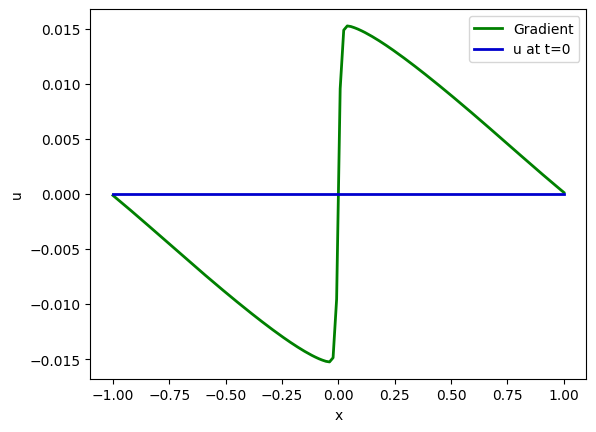

In [4]:
import pylab as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

# first gradient
fig.plot(pltx, grad[0].values.numpy('x')           , lw=2, color='green',      label="Gradient")
fig.plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue', label="u at t=0")
plt.xlabel('x'); plt.ylabel('u'); plt.legend();

# some (optional) other fields to plot:
# fig.plot(pltx,  (velocities[16]).values.numpy('x')   , lw=2, color='cyan', label="u at t=0.5")
# fig.plot(pltx,  (SOLUTION_T16).values.numpy('x')   , lw=2, color='red', label="solution at t=0.5")
# fig.plot(pltx,  (velocities[16] - SOLUTION_T16).values.numpy('x')   , lw=2, color='blue', label="difference at t=0.5")


This gives us a "search direction" for each velocity variable. Based on a linear approximation, the gradient tells us how to change each of them to increase the loss function (gradients _always_ point "upwards"). Thus, we can use the gradient to run an optimization and find an initial state `velocity` that minimizes our loss.



## Optimization

Equipped with the gradient we now run a gradient descent optimization. Below, we're using a learning rate of `LR=5`, and we're re-evaluating the loss for the updated state to track convergence.

In the following code block, we're additionally saving the gradients in a list called `grads`, such that we can visualize them later on. For a regular optimization we could of course discard the gradient after performing an update of the velocity.


In [5]:
LR = 5.

grads=[]
for optim_step in range(5):
    (loss,velocities), grad = gradient_function(velocity)
    print('Optimization step %d, loss: %f' % (optim_step,loss))
    grads.append( grad[0] )

    velocity = velocity - LR * grads[-1]


Optimization step 0, loss: 0.382915
Optimization step 1, loss: 0.326882
Optimization step 2, loss: 0.281032
Optimization step 3, loss: 0.242804
Optimization step 4, loss: 0.210666



Now we'll check well the 16th state of the simulation actually matches the target after the 5 update steps. This is what the loss measures, after all. The next graph shows the constraints (i.e. the solution we'd like to obtain) in green, and the reconstructed state after the initial state `velocity` (which we updated five times via the gradient by now) was updated 16 times by the solver.



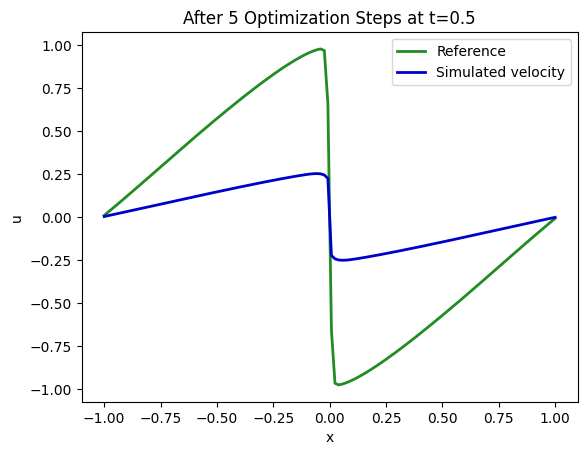

In [6]:
fig = plt.figure().gca()

# target constraint at t=0.5
fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw=2, color='forestgreen',  label="Reference")

# optimized state of our simulation after 16 steps
fig.plot(pltx, velocities[16].values.numpy('x'), lw=2, color='mediumblue', label="Simulated velocity")

plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("After 5 Optimization Steps at t=0.5");

This seems to be going in the right direction! It's definitely not perfect, but we've only computed 5 GD update steps so far. The two peaks with a positive velocity on the left side of the shock and the negative peak on the right side are starting to show.

This is a good indicator that the backpropagation of gradients through all of our 16 simulated steps is behaving correctly, and that it's driving the solution in the right direction. The graph above only hints at how powerful the setup is: the gradient that we obtain from each of the simulation steps (and each operation within them) can easily be chained together into more complex sequences. In the example above, we're backpropagating through all 16 steps of the simulation, and we could easily enlarge this "look-ahead" of the optimization with minor changes to the code.



## More optimization steps

Before moving on to more complex physics simulations, or involving NNs, let's finish the optimization task at hand, and run more steps to get a better solution.



In [7]:
import time
start = time.time()

for optim_step in range(5,50):
    (loss,velocities), grad = gradient_function(velocity)
    velocity = velocity - LR * grad[0]
    if optim_step%5==0:
      print('Optimization step %d, loss: %f' % (optim_step,loss))

end = time.time()
print("Runtime {:.2f}s".format(end-start))

Optimization step 5, loss: 0.183476
Optimization step 10, loss: 0.096224
Optimization step 15, loss: 0.054792
Optimization step 20, loss: 0.032819
Optimization step 25, loss: 0.020334
Optimization step 30, loss: 0.012852
Optimization step 35, loss: 0.008185
Optimization step 40, loss: 0.005186
Optimization step 45, loss: 0.003263
Runtime 73.34s


Thinking back to the PINN version from {doc}`diffphys-code-burgers`, the error decreases much more strongly (by ca. two orders of magnitude) with a comparable runtime. This behavior stems from DP providing gradients for the whole solutions with all its discretization points and time steps, rather than localized updates.

Let's plot again how well our solution at $t=0.5$ (blue) matches the constraints (green) now:

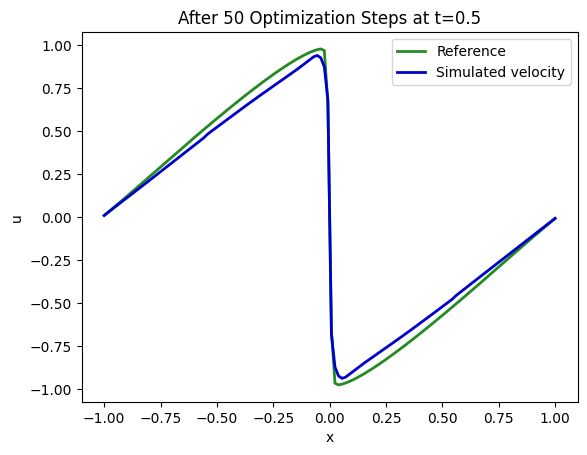

In [8]:
fig = plt.figure().gca()
fig.plot(pltx, SOLUTION_T16.values.numpy('x'), lw=2, color='forestgreen',  label="Reference")
fig.plot(pltx, velocities[16].values.numpy('x'), lw=2, color='mediumblue', label="Simulated velocity")
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("After 50 Optimization Steps at t=0.5");

Not bad. But how well is the initial state recovered via backpropagation through the 16 simulation steps? This is what we're changing, and because it's only indirectly constrained via the observation later in time there is more room to deviate from a desired or expected solution.

This is shown in the next plot:

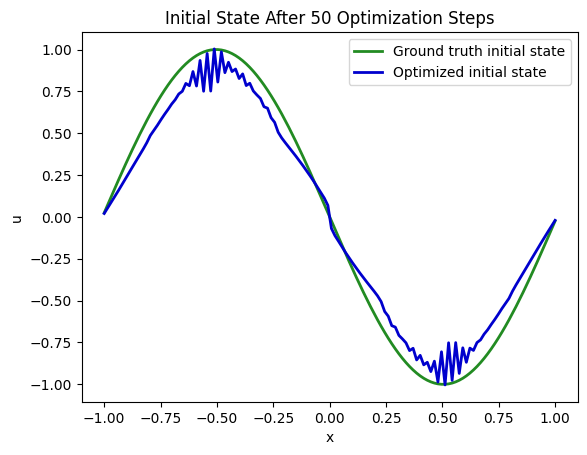

In [9]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,N)

# ground truth state at time=0 , move down
INITIAL_GT = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpy array
fig.plot(pltx, INITIAL_GT.flatten()      , lw=2, color='forestgreen', label="Ground truth initial state")  # ground truth initial state of sim
fig.plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue',  label="Optimized initial state") # manual
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.title("Initial State After 50 Optimization Steps");


Naturally, this is a tougher task: the optimization receives direct feedback what the state at $t=0.5$ should look like, but due to the non-linear model equation, we typically have a large number of solutions that exactly or numerically very closely satisfy the constraints. Hence, our minimizer does not necessarily find the exact state we started from (we can observe some numerical oscillations from the diffusion operator here with the default settings). However, the solution is still quite close in this Burgers scenario.

Before measuring the overall error of the reconstruction, let's visualize the full evolution of our system over time as this also yields the solution in the form of a numpy array that we can compare to the other versions:

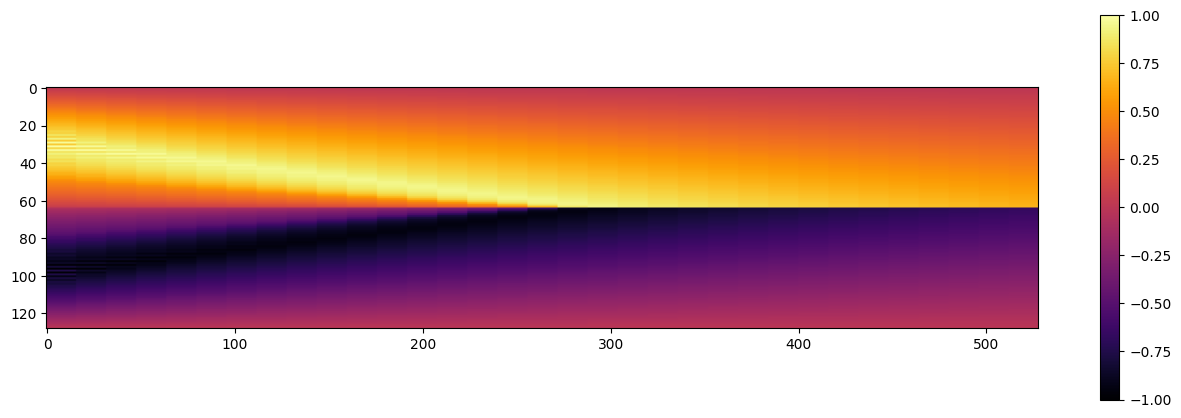

In [10]:
import pylab

def show_state(a):
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im)

# get numpy versions of all states
vels = [ x.values.numpy('x,vector') for x in velocities]
# concatenate along vector/features dimension
vels = np.concatenate(vels, axis=-1)

# save for comparison with other methods
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-diffphys-solution.npz", np.reshape(vels,[N,STEPS+1])) # remove batch & channel dimension

show_state(vels)

## Physics-informed vs. differentiable physics reconstruction

Now we have both versions, the one with the PINN, and the DP version, so let's compare both reconstructions in more detail. (Note: The following cells expect that the Burgers-forward and PINN notebooks were executed in the same environment beforehand such that the `.npz` files in the `./temp' directory are available..)

Let's first look at the solutions side by side. The code below generates an image with 3 versions, from top to bottom: the "ground truth" (GT) solution as given by the regular forward simulation, in the middle the PINN reconstruction, and at the bottom the differentiable physics version.


In [11]:
# note, this requires previous runs of the forward-sim & PINN notebooks in the same environment
sol_gt=npfile=np.load("./temp/burgers-groundtruth-solution.npz")["arr_0"]
sol_pi=npfile=np.load("./temp/burgers-pinn-solution.npz")["arr_0"]
sol_dp=npfile=np.load("./temp/burgers-diffphys-solution.npz")["arr_0"]

divider = np.ones([10,33])*-1. # we'll sneak in a block of -1s to show a black divider in the image
sbs = np.concatenate( [sol_gt, divider, sol_pi, divider, sol_dp], axis=0)

print("\nSolutions Ground Truth (top), PINN (middle) , DiffPhys (bottom):")
show_state(np.reshape(sbs,[N*3+20,33,1]))


FileNotFoundError: [Errno 2] No such file or directory: './temp/burgers-groundtruth-solution.npz'

It's quite clearly visible here that the PINN solution (in the middle) recovers the overall shape of the solution, hence the temporal constraints are at least partially fulfilled. However, it doesn't manage to capture the amplitudes of the GT solution very well.

The reconstruction from the optimization with a differentiable solver (at the bottom) is much closer to the ground truth thanks to an improved flow of gradients over the whole course of the sequence. In addition, it can leverage the grid-based discretization for both forward as well as backward passes, and in this way provide a more accurate signal to the unknown initial state. It is nonetheless visible that the reconstruction lacks certain "sharper" features of the GT version, e.g., visible in the bottom left corner of the solution image.

Let's quantify these errors over the whole sequence:

MAE PINN: 0.19298 
MAE DP:   0.06382

Error GT to PINN (top) , GT to DiffPhys (bottom):


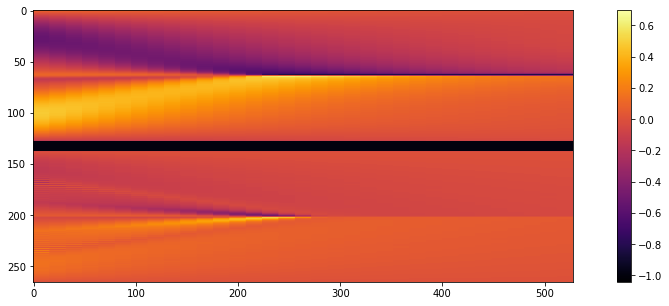

In [ ]:
err_pi = np.sum( np.abs(sol_pi-sol_gt)) / (STEPS*N)
err_dp = np.sum( np.abs(sol_dp-sol_gt)) / (STEPS*N)
print("MAE PINN: {:7.5f} \nMAE DP:   {:7.5f}".format(err_pi,err_dp))

print("\nError GT to PINN (top) , GT to DiffPhys (bottom):")
show_state(np.reshape( np.concatenate([sol_pi-sol_gt, divider, sol_dp-sol_gt],axis=0) ,[N*2+10,33,1]))

That's a pretty clear result: the PINN error is more than 3 times larger than the one from the Differentiable Physics (DP) reconstruction.

This difference also shows clearly in the jointly visualized image at the bottom: the magnitudes of the errors of the DP reconstruction are much closer to zero, as indicated by the purple color above.

A simple direct reconstruction problem like this one is always a good initial test for a DP solver. It can be tested independently before moving on to more complex setups, e.g., coupling it with an NN. If the direct optimization does not converge, there's probably still something fundamentally wrong, and there's no point involving an NN.

Now we have a first example to show similarities and differences of the two approaches. In the next section, we'll present a discussion of the findings so far, before moving to more complex cases in the following chapter.


## Next steps

As before, there's variety of things that can be improved and experimented with using the code above:

* You can try to adjust the training parameters to further improve the reconstruction.
* Activate a different optimizer, and observe the changing (not necessarily improved) convergence behavior.
* Vary the number of steps, or the resolution of the simulation and reconstruction.
* Try adding `@jit_compile` in a line before `loss_function`. This will incude a one-time compilation cost, but greatly speed up the optimization.
